In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score

In [2]:
df = pd.read_csv('Loan_default.csv')

In [3]:
df.head(2)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0


In [4]:
df.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [5]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [7]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [8]:
df['Default'].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [9]:
df['Monthly_Income'] = round((df['Income']//12), 2)

In [10]:
df['EMI'] = ((df['LoanAmount']*df['InterestRate']) + df['LoanAmount'])/(df['LoanTerm'])
df['EMI'] = round(df['EMI'], 2)

In [11]:
default_rate = pd.DataFrame(df['Default'].value_counts(normalize=True).reset_index())

In [12]:
default_rate.head()

,Default,proportion
0,0,0.883872
1,1,0.116128


In [13]:
default_rate['proportion'] = round(default_rate['proportion'], 2)
default_rate['%'] = round(default_rate['proportion']*100, 2)

In [14]:
default_rate

,Default,proportion,%
0,0,0.88,88.0
1,1,0.12,12.0


## As per the data, the loan default rate is around 12%. 29,653 customers out of 2,55,347 are most likely to default the loan.

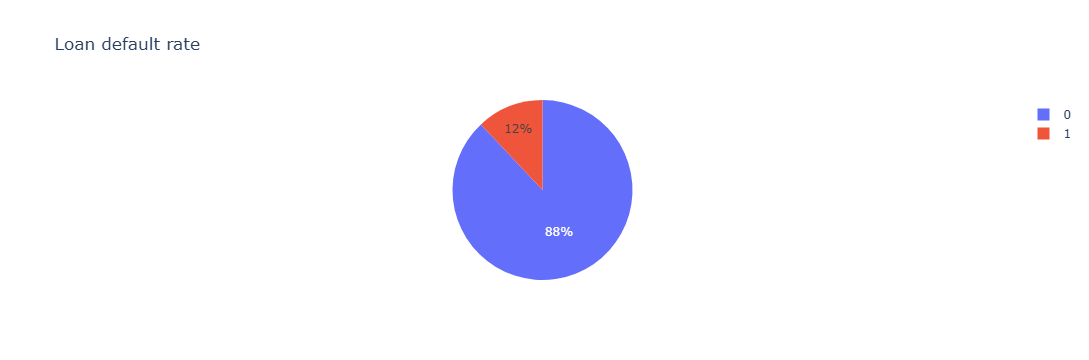

In [15]:
import plotly.express as px
px.pie(data_frame=default_rate, names='Default', values='%', title='Loan default rate')

In [16]:
X = df.drop(columns=['LoanID', 'Income', 'Default'])
y = df[['Default']]

In [17]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [18]:
numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='passthrough')

In [20]:
from catboost import CatBoostClassifier
lg_bal = LogisticRegression(max_iter=2000, 
                            class_weight='balanced', 
                            random_state=42,
                            solver='saga')

dt_bal = DecisionTreeClassifier(class_weight='balanced', random_state=42, criterion="log_loss",
                                max_depth=8, max_leaf_nodes=40, min_samples_leaf=10, min_samples_split=30)

rf_bal = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42, 
                                criterion='log_loss', max_depth=8, min_samples_split=30, 
                                max_leaf_nodes = 40, max_samples = 0.8,
                                min_samples_leaf = 10)

cat_bal = CatBoostClassifier(iterations=1200, learning_rate=0.03, class_weights=[1, 10], depth=6, random_seed=42,
                             eval_metric='AUC', loss_function='Logloss',
                             cat_features=cat_cols, verbose=False)

lgbm_bal = LGBMClassifier(num_leaves=64, max_depth=8, learning_rate=0.03,
                          n_estimators=1500, subsample=0.8, colsample_bytree=0.8,
                          reg_alpha=0.1, reg_lambda=0.1, class_weight='balanced')

In [21]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

In [23]:
df['oof_pred_lg'] = np.nan
df['oof_pred_rf'] = np.nan
df['oof_pred_dt'] = np.nan
df['oof_pred_cat'] = np.nan
df['oof_pred_lgbm'] = np.nan

In [24]:
lg_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('lg_bal', lg_bal)
])

dt_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('dt_bal', dt_bal)
])

rf_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('rf_bal', rf_bal)
])

lgbm_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('lgbm_bal', lgbm_bal)
])

In [25]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    lg_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_lg'] = lg_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [26]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    dt_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_dt'] = dt_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [27]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_rf'] = rf_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [28]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    cat_bal.fit(X_train, y_train.values.ravel(), cat_features=cat_cols)
    df.loc[test_idx, 'oof_pred_cat'] = cat_bal.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [29]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    lgbm_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_lgbm'] = lgbm_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



fold 1
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



fold 2
[LightGBM] [Info] Number of positive: 23723, number of negative: 180555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 204278, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



fold 3
[LightGBM] [Info] Number of positive: 23723, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 204278, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



fold 4
[LightGBM] [Info] Number of positive: 23722, number of negative: 180556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1585
[LightGBM] [Info] Number of data points in the train set: 204278, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\aksha\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [30]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,LoanPurpose,HasCoSigner,Default,Monthly_Income,EMI,oof_pred_lg,oof_pred_rf,oof_pred_dt,oof_pred_cat,oof_pred_lgbm
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,Other,Yes,0,7166,22806.31,0.181523,0.302196,0.247606,0.246394,0.205948
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,Other,Yes,0,4202,12049.94,0.164889,0.299532,0.146191,0.195092,0.083709
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,Auto,No,1,7017,119337.42,0.662929,0.543752,0.563349,0.701372,0.687416
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,Business,No,0,2642,15063.66,0.588239,0.495064,0.432283,0.535486,0.312961
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,Auto,No,0,1703,1429.87,0.411672,0.395913,0.275433,0.175741,0.065468


In [31]:
df['oof_pred_lg'] = round(df['oof_pred_lg'], 2)
df['oof_pred_rf'] = round(df['oof_pred_rf'], 2)
df['oof_pred_dt'] = round(df['oof_pred_dt'], 2)
df['oof_pred_cat'] = round(df['oof_pred_cat'], 2)
df['oof_pred_lgbm'] = round(df['oof_pred_lgbm'], 2)

In [32]:
print(f'ROC-AUC score for logistic regression:-{roc_auc_score(y, df["oof_pred_lg"])}')
print(f'ROC-AUC score for Random Forest:-{roc_auc_score(y, df["oof_pred_rf"])}')
print(f'ROC-AUC score for Decision Tree:-{roc_auc_score(y, df["oof_pred_dt"])}')
print(f'ROC-AUC score for Catboost:-{roc_auc_score(y, df["oof_pred_cat"])}')
print(f'ROC-AUC score for LightGBM:-{roc_auc_score(y, df["oof_pred_lgbm"])}')

ROC-AUC score for logistic regression:-0.7477250308575152
ROC-AUC score for Random Forest:-0.7385997661824097
ROC-AUC score for Decision Tree:-0.7178046541114586
ROC-AUC score for Catboost:-0.7535830064274736
ROC-AUC score for LightGBM:-0.7433763403362189


In [33]:
from sklearn.metrics import average_precision_score
print(f'PR-AUC score for logistic regression:-{average_precision_score(y, df["oof_pred_lg"])}')
print(f'PR-AUC score for Random Forest:-{average_precision_score(y, df["oof_pred_rf"])}')
print(f'PR-AUC score for Decision Tree:-{average_precision_score(y, df["oof_pred_dt"])}')
print(f'PR-AUC score for Catboost:-{average_precision_score(y, df["oof_pred_cat"])}')
print(f'PR-AUC score for LightGBM:-{average_precision_score(y, df["oof_pred_lgbm"])}')

PR-AUC score for logistic regression:-0.299576414846072
PR-AUC score for Random Forest:-0.2896940362801023
PR-AUC score for Decision Tree:-0.25917509523411736
PR-AUC score for Catboost:-0.31917643579878835
PR-AUC score for LightGBM:-0.30783335202123596


In [34]:
df['pred_lg'] = (df['oof_pred_lg'] >= 0.45).astype(int)
df['pred_rf'] = (df['oof_pred_rf'] >= 0.45).astype(int)
df['pred_dt'] = (df['oof_pred_dt'] >= 0.45).astype(int)
df['pred_cat'] = (df['oof_pred_cat'] >= 0.45).astype(int)
df['pred_lgbm'] = (df['oof_pred_lgbm'] >= 0.45).astype(int)

In [35]:
print(f'Confusion matrix for logistic regression:-\n{confusion_matrix(y, df["pred_lg"])}')
print(f'Confusion matrix score for Random Forest:-\n{confusion_matrix(y, df["pred_rf"])}')
print(f'Confusion matrix score for Decision Tree:-\n{confusion_matrix(y, df["pred_dt"])}')
print(f'Confusion matrix score for Catboost:-\n{confusion_matrix(y, df["pred_cat"])}')
print(f'Confusion matrix score for LightGBM:-\n{confusion_matrix(y, df["pred_lgbm"])}')

Confusion matrix for logistic regression:-
[[133019  92675]
 [  6963  22690]]
Confusion matrix score for Random Forest:-
[[114141 111553]
 [  5522  24131]]
Confusion matrix score for Decision Tree:-
[[124441 101253]
 [  7260  22393]]
Confusion matrix score for Catboost:-
[[117697 107997]
 [  5378  24275]]
Confusion matrix score for LightGBM:-
[[157627  68067]
 [ 10090  19563]]


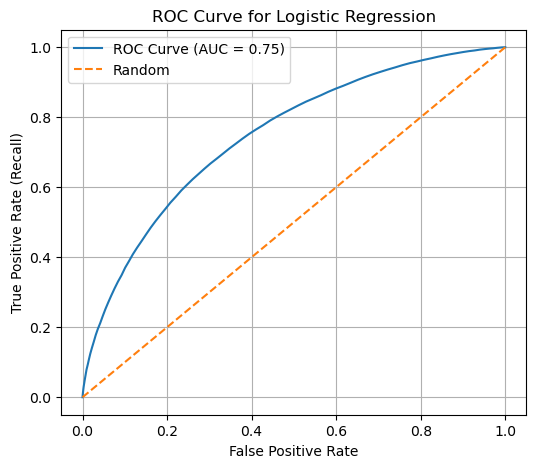

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, df['oof_pred_lg'])
roc_auc = roc_auc_score(y, df['oof_pred_lg'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

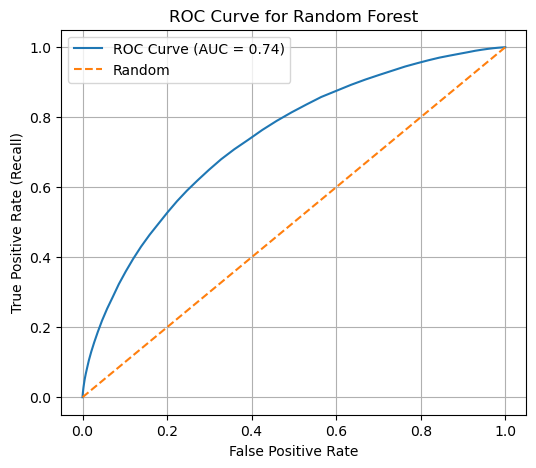

In [37]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_rf'])
roc_auc = roc_auc_score(y, df['oof_pred_rf'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.grid(True)
plt.show()

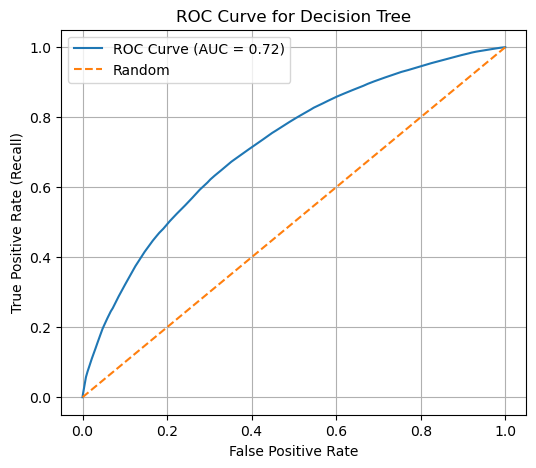

In [38]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_dt'])
roc_auc = roc_auc_score(y, df['oof_pred_dt'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

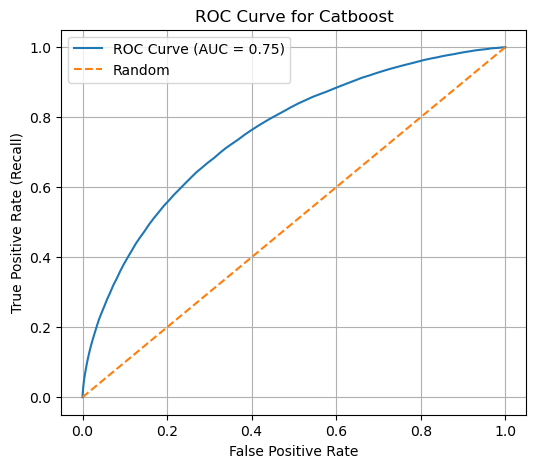

In [39]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_cat'])
roc_auc = roc_auc_score(y, df['oof_pred_cat'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Catboost")
plt.legend()
plt.grid(True)
plt.show()

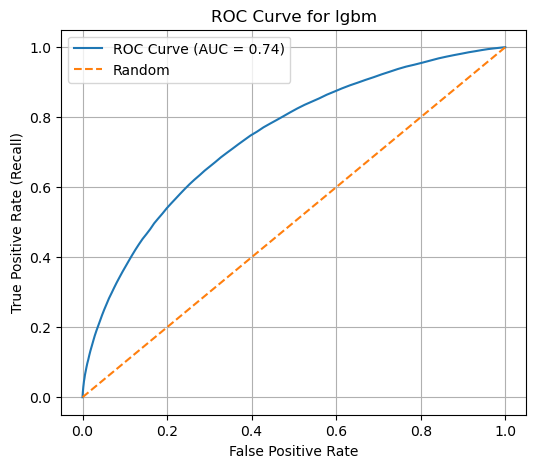

In [40]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_lgbm'])
roc_auc = roc_auc_score(y, df['oof_pred_lgbm'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for lgbm")
plt.legend()
plt.grid(True)
plt.show()

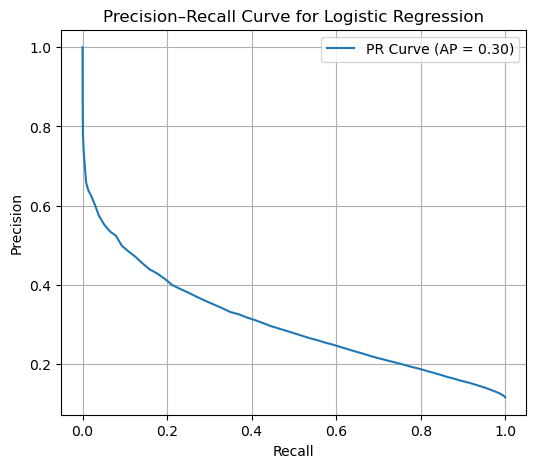

In [41]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_lg'])
pr_auc = average_precision_score(y, df['oof_pred_lg'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

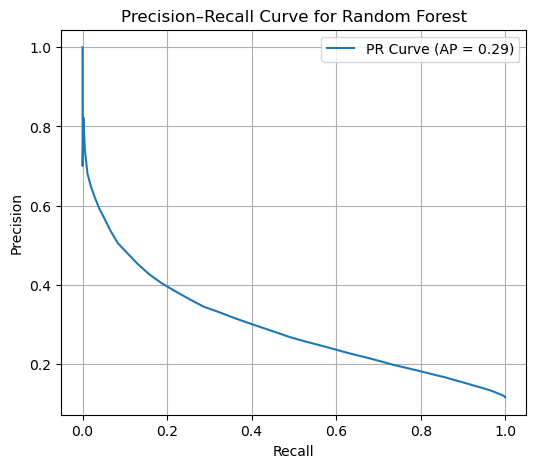

In [42]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_rf'])
pr_auc = average_precision_score(y, df['oof_pred_rf'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Random Forest")
plt.legend()
plt.grid(True)
plt.show()

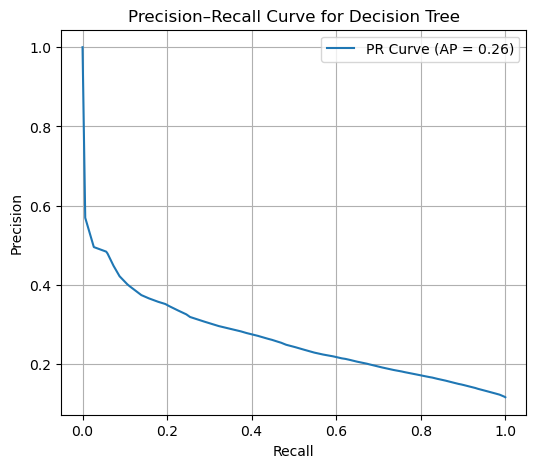

In [43]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_dt'])
pr_auc = average_precision_score(y, df['oof_pred_dt'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

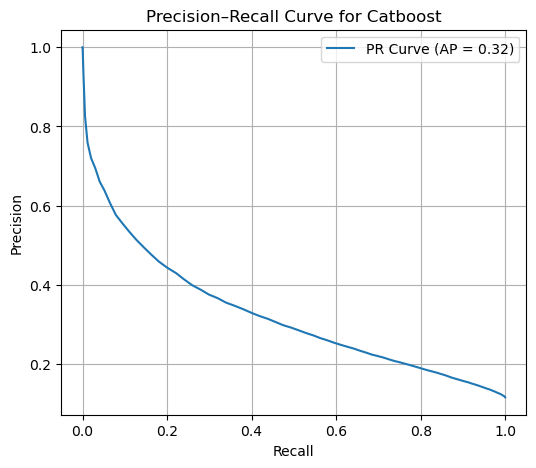

In [44]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_cat'])
pr_auc = average_precision_score(y, df['oof_pred_cat'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Catboost")
plt.legend()
plt.grid(True)
plt.show()

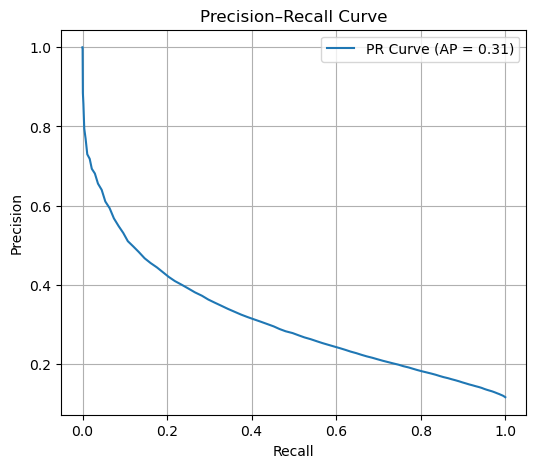

In [45]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_lgbm'])
pr_auc = average_precision_score(y, df['oof_pred_lgbm'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
tn, fp, fn, tp = confusion_matrix(y, df['pred_lg']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
lg_cm = {
    'model': 'Logistic Regression',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_rf']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
rf_cm = {
    'model': 'Random Forest',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_dt']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
dt_cm = {
    'model': 'Decision Tree',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_cat']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
cat_cm = {
    'model': 'Catboost',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_lgbm']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
cat_lgbm = {
    'model': 'LightGBM',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

In [47]:
cm_df = pd.DataFrame([lg_cm, rf_cm, dt_cm, cat_cm, cat_lgbm])

In [48]:
cm_df = cm_df.sort_values(by='False Negatives', ascending=True)

In [49]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR)
3,Catboost,117697,107997,5378,24275,0.555996,0.183523,0.818636
1,Random Forest,114141,111553,5522,24131,0.541506,0.177847,0.813779
0,Logistic Regression,133019,92675,6963,22690,0.609794,0.196680,0.765184
2,Decision Tree,124441,101253,7260,22393,0.575037,0.181106,0.755168
4,LightGBM,157627,68067,10090,19563,0.693918,0.223245,0.659731


In [50]:
cm_df['Default_risk_rate(FNR)'] = cm_df['False Negatives']/(cm_df['False Negatives'] + cm_df['True Positives'])

In [51]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR),Default_risk_rate(FNR)
3,Catboost,117697,107997,5378,24275,0.555996,0.183523,0.818636,0.181364
1,Random Forest,114141,111553,5522,24131,0.541506,0.177847,0.813779,0.186221
0,Logistic Regression,133019,92675,6963,22690,0.609794,0.196680,0.765184,0.234816
2,Decision Tree,124441,101253,7260,22393,0.575037,0.181106,0.755168,0.244832
4,LightGBM,157627,68067,10090,19563,0.693918,0.223245,0.659731,0.340269


In [52]:
cm_df['Accuracy'] = round(cm_df['Accuracy'], 2)
cm_df['Precision'] = round(cm_df['Precision'], 2)
cm_df['Recall(TPR)'] = round(cm_df['Recall(TPR)'], 2)
cm_df['Default_risk_rate(FNR)%'] = round(cm_df['Default_risk_rate(FNR)']*100, 2)

In [53]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR),Default_risk_rate(FNR),Default_risk_rate(FNR)%
3,Catboost,117697,107997,5378,24275,0.56,0.18,0.82,0.181364,18.14
1,Random Forest,114141,111553,5522,24131,0.54,0.18,0.81,0.186221,18.62
0,Logistic Regression,133019,92675,6963,22690,0.61,0.20,0.77,0.234816,23.48
2,Decision Tree,124441,101253,7260,22393,0.58,0.18,0.76,0.244832,24.48
4,LightGBM,157627,68067,10090,19563,0.69,0.22,0.66,0.340269,34.03


In [54]:
cm_df['F1-score'] = 2*((cm_df['Precision']*cm_df['Recall(TPR)'])/(cm_df['Precision']+cm_df['Recall(TPR)']))

In [55]:
cm_df['threshold'] = 0.45

In [56]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR),Default_risk_rate(FNR),Default_risk_rate(FNR)%,F1-score,threshold
3,Catboost,117697,107997,5378,24275,0.56,0.18,0.82,0.181364,18.14,0.295200,0.45
1,Random Forest,114141,111553,5522,24131,0.54,0.18,0.81,0.186221,18.62,0.294545,0.45
0,Logistic Regression,133019,92675,6963,22690,0.61,0.20,0.77,0.234816,23.48,0.317526,0.45
2,Decision Tree,124441,101253,7260,22393,0.58,0.18,0.76,0.244832,24.48,0.291064,0.45
4,LightGBM,157627,68067,10090,19563,0.69,0.22,0.66,0.340269,34.03,0.330000,0.45


In [57]:
import joblib
joblib.dump(rf_bal_pipe, 'C:/Users/aksha/Documents/loan_pred_model_v1.joblib')

['C:/Users/aksha/Documents/loan_pred_model_v1.joblib']

In [58]:
cm_df.to_csv('C:/Users/aksha/Documents/confusion_matrix.csv', index=False)

In [59]:
joblib.dump(cat_bal, 'C:/Users/aksha/Documents/catboost_model_v1.joblib')

['C:/Users/aksha/Documents/catboost_model_v1.joblib']

In [60]:
cat_cols

['Education',
 'EmploymentType',
 'MaritalStatus',
 'HasMortgage',
 'HasDependents',
 'LoanPurpose',
 'HasCoSigner']

In [61]:
features_df = pd.DataFrame({
    'features': X_train.columns,
    'importances': cat_bal.feature_importances_
})

In [62]:
features_df.sort_values(by='importances', ascending=False)

,features,importances
0,Age,18.445455
5,InterestRate,13.661665
15,Monthly_Income,13.214406
3,MonthsEmployed,11.704208
16,EMI,9.147452
1,LoanAmount,8.927292
2,CreditScore,6.499193
7,DTIRatio,6.043767
4,NumCreditLines,2.305065
9,EmploymentType,1.991313


In [63]:
df[df['Age'] > df['Age'].median()]['Default'].value_counts()

Default
0    118690
1      8904
Name: count, dtype: int64

In [64]:
df[df['Age'] < df['Age'].median()]['Default'].value_counts()

Default
0    102548
1     20240
Name: count, dtype: int64

In [65]:
X[num_cols].corrwith(df['Default'])

Age              -0.167783
LoanAmount        0.086659
CreditScore      -0.034166
MonthsEmployed   -0.097374
NumCreditLines    0.028330
InterestRate      0.131273
LoanTerm          0.000545
DTIRatio          0.019236
Monthly_Income   -0.099120
EMI               0.103871
dtype: float64

In [66]:
X[num_cols].corr()

,Age,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Monthly_Income,EMI
Age,1.000000,-0.002213,-0.000548,-0.000341,-0.000890,-0.001127,0.000263,-0.004689,-0.001244,-0.002253
LoanAmount,-0.002213,1.000000,0.001261,0.002817,0.000794,-0.002291,0.002538,0.001122,-0.000865,0.501132
CreditScore,-0.000548,0.001261,1.000000,0.000613,0.000016,0.000436,0.001130,-0.001039,-0.001430,0.000379
MonthsEmployed,-0.000341,0.002817,0.000613,1.000000,0.001267,0.000096,-0.001166,0.001765,0.002675,0.002142
NumCreditLines,-0.000890,0.000794,0.000016,0.001267,1.000000,-0.000297,-0.000226,-0.000586,-0.002016,0.001558
InterestRate,-0.001127,-0.002291,0.000436,0.000096,-0.000297,1.000000,0.000892,0.000575,-0.002303,0.413514
LoanTerm,0.000263,0.002538,0.001130,-0.001166,-0.000226,0.000892,1.000000,0.002273,-0.000998,-0.517585
DTIRatio,-0.004689,0.001122,-0.001039,0.001765,-0.000586,0.000575,0.002273,1.000000,0.000205,-0.000716
Monthly_Income,-0.001244,-0.000865,-0.001430,0.002675,-0.002016,-0.002303,-0.000998,0.000205,1.000000,-0.001969
EMI,-0.002253,0.501132,0.000379,0.002142,0.001558,0.413514,-0.517585,-0.000716,-0.001969,1.000000


In [85]:
# Custom attrition risk bucket
bins = [0.0, 0.30, 0.60, 1.0] 
labels = ['Low Risk', 'Medium Risk', 'High Risk'] 
df['Default_risk_bucket'] = pd.cut(df['oof_pred_cat'], bins=bins, labels=labels)

In [86]:
default_risk_df = pd.DataFrame(df['Default_risk_bucket'].value_counts(normalize=True).reset_index())

In [87]:
default_risk_df['percent(%)'] = round(default_risk_df['proportion']*100, 2)

In [88]:
default_risk_df

,Default_risk_bucket,proportion,percent(%)
0,Medium Risk,0.451785,45.18
1,High Risk,0.285367,28.54
2,Low Risk,0.262848,26.28


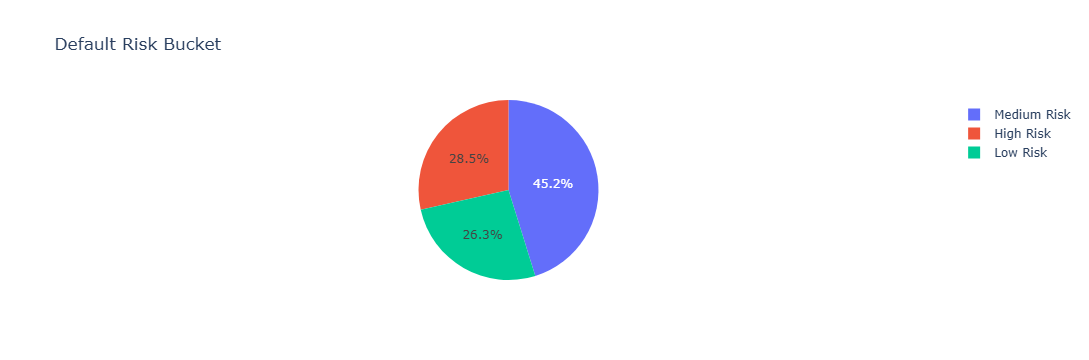

In [89]:
px.pie(title='Default Risk Bucket', data_frame=default_risk_df, 
       names='Default_risk_bucket', values='percent(%)')